In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [31]:
pumpkins = pd.read_csv('US-pumpkins.csv')
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

columns_to_select = ['Package', 'Variety', 'City Name', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.loc[:, columns_to_select]

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

In [32]:
month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt - datetime(dt.year, 1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear': day_of_year,
     'Variety': pumpkins['Variety'],
     'City': pumpkins['City Name'],
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'], 
     'High Price': pumpkins['High Price'], 
     'Price': price
     }
)

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/(1 + 1/9)
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price/(1/2)

new_pumpkins.head()

C:\Users\ychwa\AppData\Local\Temp\ipykernel_52276\283350579.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt - datetime(dt.year, 1,1)).days)


Month  DayOfYear   Variety       City               Package  Low Price   
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0  \
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price  Price  
70        15.0   13.5  
71        18.0   16.2  
72        18.0   16.2  
73        17.0   15.3  
74        15.0   13.5

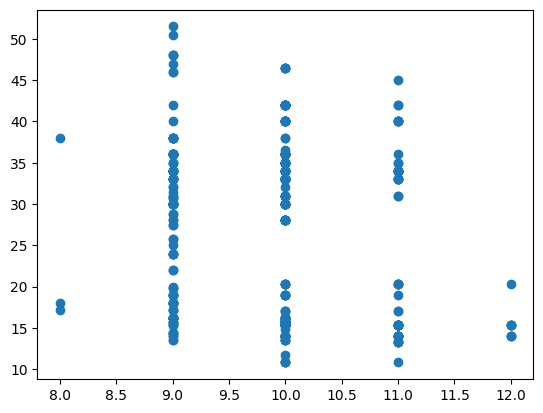

In [33]:
plt.scatter('Month','Price',data=new_pumpkins)

In [34]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.1491291363427862
-0.16690092505934478


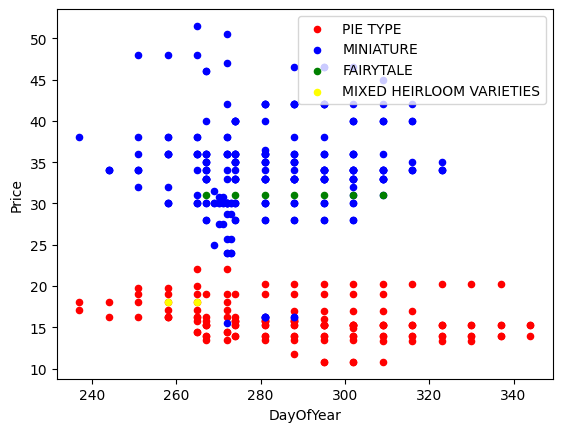

In [35]:
ax = None
colors = ['red', 'blue', 'green', 'yellow']

for i, var in enumerate(new_pumpkins['Variety'].unique()):
    df = new_pumpkins[new_pumpkins['Variety'] == var]
    ax = df.plot.scatter('DayOfYear', 'Price', ax = ax, color = colors[i], label = var)

<Axes: xlabel='Variety'>

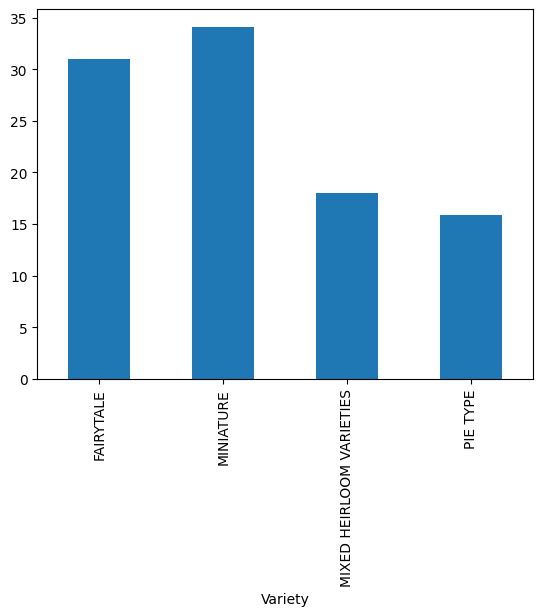

In [36]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

<Axes: xlabel='DayOfYear', ylabel='Price'>

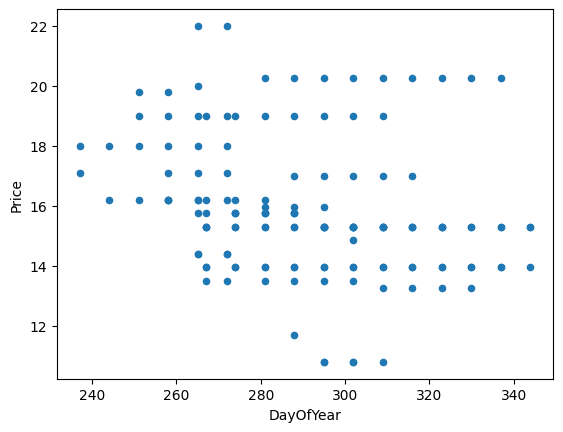

In [37]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety'] == 'PIE TYPE']
pie_pumpkins.plot.scatter('DayOfYear', 'Price')

In [38]:
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))

-0.26678559691441883


In [39]:
pie_pumpkins.dropna(inplace=True)
pie_pumpkins.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144 entries, 70 to 1630
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    int32  
 1   DayOfYear   144 non-null    int64  
 2   Variety     144 non-null    object 
 3   City        144 non-null    object 
 4   Package     144 non-null    object 
 5   Low Price   144 non-null    float64
 6   High Price  144 non-null    float64
 7   Price       144 non-null    float64
dtypes: float64(3), int32(1), int64(1), object(3)
memory usage: 9.6+ KB


C:\Users\ychwa\AppData\Local\Temp\ipykernel_52276\3144308612.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pie_pumpkins.dropna(inplace=True)


In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [41]:
X = pie_pumpkins['DayOfYear'].values.reshape(-1,1)
y = pie_pumpkins['Price'].values

print(pie_pumpkins['DayOfYear'].shape)
print(X.shape)
print(y.shape)

(144,)
(144, 1)
(144,)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [45]:
pred = lin_reg.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse / np.mean(pred) * 100:3.3}%)')

Mean error: 2.76 (17.3%)


In [46]:
score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Model determination:  0.04499342423558461


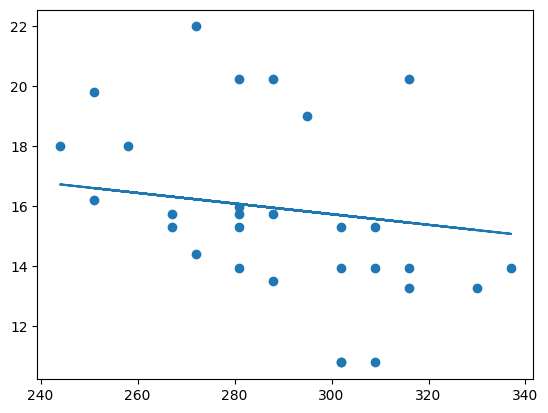

In [47]:
plt.scatter(X_test, y_test)
plt.plot(X_test, pred)

In [48]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [53]:
pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train, y_train)
pred = pipeline.predict(X_test)
mse = np.sqrt(mean_squared_error(y_test, pred))
print(f'Mean error: {mse:3.3} ({mse / np.mean(pred) * 100:3.3}%)')

score = lin_reg.score(X_train, y_train)
print('Model determination: ', score)

Mean error: 2.73 (17.2%)
Model determination:  0.04499342423558461


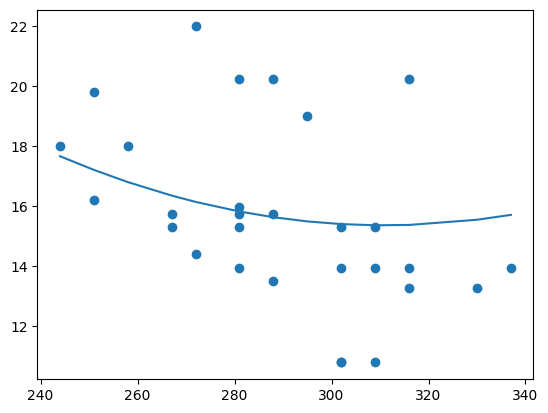

In [54]:
plt.scatter(X_test, y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

In [55]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70        False      False                     False      True
71        False      False                     False      True
72        False      False                     False      True
73        False      False                     False      True
74        False      False                     False      True
...         ...        ...                       ...       ...
1738      False       True                     False     False
1739      False       True                     False     False
1740      False       True                     False     False
1741      False       True                     False     False
1742      False       True                     False     False

[415 rows x 4 columns]

In [56]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())
pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.25 (8.34%)
Model determination:  0.9643700222967562


In [59]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(332, 20)
(83, 20)
(332,)
(83,)
